<a href="https://colab.research.google.com/github/IsaacFigNewton/Analyzing-Hate-Crime-Data/blob/main/Hate_Crime_Data_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TODO:
####Refactor multi-column parsing code for bias_desc, victim_types, and offense_name
####include offense_name in categorical data once you've refactored multicol parsing
####Add the ethnicity_race_cols to demo_df

#Import Stuff

###Import all libraries

In [1]:
import pandas as pd
import sklearn as sk
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import altair as alt
import re

###Import datasets

In [2]:
crime_df = pd.read_csv("https://raw.githubusercontent.com/IsaacFigNewton/Analyzing-Hate-Crime-Data/main/hate_crime/hate_crime.csv", on_bad_lines='skip')
city_demo_df = pd.read_csv("https://raw.githubusercontent.com/IsaacFigNewton/Analyzing-Hate-Crime-Data/main/demographics/city/ACSST1Y2022.S0101-Data.csv", on_bad_lines='skip')
county_demo_df = pd.read_csv("https://raw.githubusercontent.com/IsaacFigNewton/Analyzing-Hate-Crime-Data/main/demographics/county/ACSDP1Y2022.DP05-Data.csv", on_bad_lines='skip')

#Data Cleaning

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
#only consider 2022 crime data from cities and counties
crime_df = crime_df[(crime_df['data_year'] == 2022) & ((crime_df['agency_type_name'] == "City") | (crime_df['agency_type_name'] == "County"))]

##Clean city and county demographic datasets

In [5]:
# use the entries of the first row as the column headers for easier management
def fixHeaders(df):
  new_headers = df.iloc[0]
  new_df = df[1:]
  new_df.columns = new_headers
  return new_df

In [6]:
#fix the headers
city_demo_df = fixHeaders(city_demo_df)
county_demo_df = fixHeaders(county_demo_df)

###Create area columns

In [7]:
def split_area_name(area):
    result = [np.nan, np.nan, np.nan]
    if ", " in area:
        result = area.split(", ") + [np.nan]
    if " city" in result[0].lower():
        result[0] = result[0][0:-5]
        result[2] = result[1]
        result[1] = "City"
    elif " county" in result[0].lower():
        result[0] = result[0][0:-7]
        result[2] = result[1]
        result[1] = "County"

    return result + [np.nan] * (3 - len(result))

def splitArea(df):
    df[["pug_agency_name", "agency_type_name", "state_name"]] = df["Geographic Area Name"].map(split_area_name).apply(pd.Series)

In [8]:
splitArea(city_demo_df)
splitArea(county_demo_df)

# city_demo_df.head()

###Fix column names



In [9]:
def fix_column_names(df):
  removalList = {"SEX AND AGE!!", "SEX AND ", "Estimate!!", "Total!!", "Total population!!", "CITIZEN, VOTING AGE POPULATION!!", "AGE!!"}

  new_cols = []
  for col in df.columns:
    col = str(col)
    for term in removalList:
      if term in col:
        col = col.replace(term, "")
    new_cols.append(col)

  return new_cols

county_demo_df.columns = fix_column_names(county_demo_df)
city_demo_df.columns = fix_column_names(city_demo_df)

###Add and remove columns to line the dataframes up

In [10]:
#combine the city_df age-related columns as needed to merge better with the county_demo_df
def combine_city_df_cols(df_s0101):
    formatted_df = df_s0101.copy(deep=True)

    formatted_df['25 to 34 years'] = df_s0101['25 to 29 years'] + df_s0101['30 to 34 years']
    formatted_df['35 to 44 years'] = df_s0101['35 to 39 years'] + df_s0101['40 to 44 years']
    formatted_df['45 to 54 years'] = df_s0101['45 to 49 years'] + df_s0101['50 to 54 years']
    formatted_df['65 to 74 years'] = df_s0101['65 to 69 years'] + df_s0101['70 to 74 years']
    formatted_df['75 to 84 years'] = df_s0101['75 to 79 years'] + df_s0101['80 to 84 years']

    return formatted_df

city_demo_df = combine_city_df_cols(city_demo_df)
# city_demo_df

In [11]:
# fix any missing values
city_demo_df = city_demo_df.replace("(X)", np.nan)
county_demo_df = county_demo_df.replace("(X)", np.nan)

In [12]:
#drop all margin of error columns from the city and county dataframes
city_demo_df.drop(columns=list(city_demo_df.filter(regex = "Margin of Error")), inplace = True)
county_demo_df.drop(columns=list(county_demo_df.filter(regex = "Margin of Error")), inplace = True)

###Fix column data types

In [13]:
city_percent_age_cols = list(set(list(city_demo_df.filter(regex = "Percent")) + list(city_demo_df.filter(regex = "ratio")) + list(city_demo_df.filter(regex = "years"))))
county_percent_age_cols = list(set(list(county_demo_df.filter(regex = "Percent")) + list(city_demo_df.filter(regex = "ratio")) + list(county_demo_df.filter(regex = "years"))))

for column in city_percent_age_cols:
    city_demo_df = city_demo_df[~city_demo_df[column].astype(str).str.contains('N')]

# for column in county_percent_age_cols:
#     # print(county_demo_df[column].astype(str))
#     county_demo_df = county_demo_df[~county_demo_df[column].astype(str).str.contains('N')]

city_demo_df[city_percent_age_cols] = city_demo_df[city_percent_age_cols].astype(float)
# city_demo_df[county_percent_age_cols] = city_demo_df[county_percent_age_cols].astype(float)

In [14]:
# Convert the quantitative columns to int types
# continuous quantitative variables
continuous_int_columns = ["Total population", "Under 5 years", "5 to 9 years", "45 to 54 years", "10 to 14 years", "75 to 84 years", "60 to 64 years",\
                      "25 to 34 years", "15 to 19 years", "20 to 24 years", "35 to 44 years", "55 to 59 years", "65 to 74 years",\
                      "85 years and over"]# + list(city_demo_df.filter(regex = "Total population"))))

for column in continuous_int_columns:
    city_demo_df = city_demo_df[~city_demo_df[column].astype(str).str.contains('N')]
    county_demo_df = county_demo_df[~county_demo_df[column].astype(str).str.contains('N')]

city_demo_df[continuous_int_columns] = city_demo_df[continuous_int_columns].astype(int)
county_demo_df[continuous_int_columns] = county_demo_df[continuous_int_columns].astype(int)

In [15]:
county_demo_df.dtypes

Geography                                                                                                                                         object
Geographic Area Name                                                                                                                              object
Total population                                                                                                                                   int64
Male                                                                                                                                              object
Female                                                                                                                                            object
Sex ratio (males per 100 females)                                                                                                                 object
Under 5 years                                                                     

In [16]:
age_groups = ['Under 5 years', '5 to 9 years', '10 to 14 years', '15 to 19 years', '20 to 24 years', '25 to 34 years', '35 to 44 years', '45 to 54 years', '55 to 59 years', '60 to 64 years', '65 to 74 years', '75 to 84 years', '85 years and over']

###Drop more invalid data

In [17]:
# city_demo_df.head()

In [18]:
# for group in age_groups:
#     city_demo_df = city_demo_df[city_demo_df[group] < 10**7]
#     county_demo_df = county_demo_df[county_demo_df[group] < 10**7]
#
# city_demo_df.head()

##Clean crime dataset

###Important functions

In [19]:
def get_max_cols(df, column, character, prefix):
    max = 0

    # for each entry
    for i in df.index:
      val = df.loc[i, column]

      if val != np.nan and type(val) != float:
        # Count occurrences of character in the specified column
        # then store the result in the prefix + "_req_cols" column
        # try:
        temp = len(str(val).split(character))
        # except:
        #     print(val)

        if temp > max:
          max = temp
          # print(max)

      else:
        print("val was np.nan or float; unable to parse")

      return max

In [20]:
max_cols = 0

def split_types(val):
  # break up the col_vals into individual col_vals
  col_vals = str(val).split(";")
  for i in range(len(col_vals)):
      col_vals[i] = col_vals[i].strip()

  # add placeholders
  col_vals = col_vals + [np.nan] * (max_cols - len(col_vals))

  return col_vals

In [21]:
def split_multiCol(df, column, replacementDict, max_columns):
    for i in df.index:
      if type(df.loc[i, column]) == str:
        # and for each replacement to be made
        for before, after in replacementDict.items():
          df.loc[i, column] = df.loc[i, column].replace(before, after)
        # remove extra whitespace
        df.loc[i, column].strip()

    # change max_cols here, since you can't do it from the mapping function
    max_cols = max_columns

    return df[column].map(split_types).apply(pd.Series)

In [22]:
def get_unique_types(df, type_cols):
  all_types = []
  for col in type_cols:
    all_types.extend(df[col].unique())

  # create a set of just the unique ones
  unique_types = set(all_types)

  # remove 0, which got in there somehow
  unique_types.remove(0)

  return unique_types

In [23]:
def get_unique_dummies(df, unique_types):
  unique_dummies = pd.get_dummies(list(unique_types))

  # combine the dummy columns with crime_df
  df = pd.concat([df, unique_dummies], axis=1)

  # set all dummy values to 0
  df.loc[:, unique_dummies.columns] = 0

  return unique_dummies

###Break up incident date information

In [24]:
def split_incident_date(date):
    result = date.split("-")

    return result + [np.nan] * (3 - len(result))

crime_df[["data_year", "incident_month", "incident_day"]] = crime_df["incident_date"].map(split_incident_date).apply(pd.Series)

###Break up bias descriptions into dummy columns

####Parse the bias_desc's into their own individual columns

In [25]:
# TODO: find max bias count in mapping function below?
max_bias_count = 5

def split_bias_desc(desc):
  # break up the biases into individual biases
  biases = str(desc).split(";")
  for i in range(len(biases)):
      biases[i] = biases[i]\
                    .replace("(Male)", "")\
                    .replace("(Female)", "")\
                    .replace("Lesbian, Gay, Bisexual, or Transgender (Mixed Group)", "LGBTQ")\
                    .strip()

  # add placeholders
  biases = biases + [np.nan] * (max_bias_count - len(biases))

  return biases

In [26]:
bias_cols = ["bias" + str(i) for i in range(max_bias_count)]

crime_df[bias_cols] = crime_df["bias_desc"]\
                          .map(split_bias_desc)\
                          .apply(pd.Series)

# remove the "0" column, which I'm not entirely sure why exists
if "0" in crime_df.columns:
  crime_df = crime_df.drop(columns=["0"])

In [27]:
# max_bias_desc_cols = get_max_cols(crime_df, "bias_desc", ";", "bias_desc")

# bias_cols = ["bias" + str(i) for i in range(max_bias_desc_cols)]

# def split_bias_desc(val):
#   return split_multiCol(val, {"(Male)":"", "(Female)":"", "Lesbian, Gay, Bisexual, or Transgender (Mixed Group)": "LGBTQ"}, max_bias_desc_cols)

# crime_df[bias_cols] = crime_df["bias_desc"]\
#                           .map(split_bias_desc)\
#                           .apply(pd.Series)

# # remove the "0" column, which I'm not entirely sure why exists
# if "0" in crime_df.columns:
#   crime_df = crime_df.drop(columns=["0"])

####Get a list of all unique biases

In [28]:
all_biases = []
for col in bias_cols:
  all_biases.extend(crime_df[col].unique())

# create a set of just the unique ones
unique_biases = set(all_biases)

# remove 0, which got in there somehow
unique_biases.remove(np.nan)

In [29]:
unique_biases

{'Anti-American Indian or Alaska Native',
 'Anti-Arab',
 'Anti-Asian',
 'Anti-Atheism/Agnosticism',
 'Anti-Bisexual',
 'Anti-Black or African American',
 'Anti-Buddhist',
 'Anti-Catholic',
 'Anti-Church of Jesus Christ',
 'Anti-Eastern Orthodox (Russian, Greek, Other)',
 'Anti-Female',
 'Anti-Gay',
 'Anti-Gender Non-Conforming',
 'Anti-Heterosexual',
 'Anti-Hindu',
 'Anti-Hispanic or Latino',
 'Anti-Islamic (Muslim)',
 "Anti-Jehovah's Witness",
 'Anti-Jewish',
 'Anti-LGBTQ',
 'Anti-Lesbian',
 'Anti-Male',
 'Anti-Mental Disability',
 'Anti-Multiple Races, Group',
 'Anti-Multiple Religions, Group',
 'Anti-Native Hawaiian or Other Pacific Islander',
 'Anti-Other Christian',
 'Anti-Other Race/Ethnicity/Ancestry',
 'Anti-Other Religion',
 'Anti-Physical Disability',
 'Anti-Protestant',
 'Anti-Sikh',
 'Anti-Transgender',
 'Anti-White'}

####Create dummy columns for all hate crime biases

In [30]:
dummies = pd.get_dummies(list(unique_biases))

# combine the dummy columns with crime_df
crime_df = pd.concat([crime_df, dummies], axis=1)

# set all dummy values to 0
crime_df.loc[:, dummies.columns] = 0

In [31]:
#set dummy column values according to biases parsed from bias_desc

# for each entry
for i in crime_df.index:
    # for each bias column
    for j in range(0, 5):
        bias = crime_df.loc[i]["bias" + str(j)]
        if bias in unique_biases:
            # Use the iloc method to access the DataFrame by row and column indices
            crime_df.loc[i, bias] = 1

###Break victim_types column up into dummy columns

In [32]:
crime_df.reset_index()

####Parse the victim_types into their own individual columns

In [33]:
# TODO: find max bias count in mapping function below?
max_bias_count = 5

def split_victim_types(desc):
  # break up the victims into individual victims
  victims = str(desc).split(";")
  for i in range(len(victims)):
      victims[i] = victims[i].strip()

  # add placeholders
  victims = victims + [np.nan] * (max_bias_count - len(victims))

  return victims

In [ ]:
victim_type_cols = ["victim_type_" + str(i) for i in range(max_bias_count)]

crime_df[victim_type_cols] = crime_df["victim_types"]\
                          .map(split_victim_types)\
                          .apply(pd.Series)

# remove the "0" column, which I'm not entirely sure why exists
if np.nan in crime_df.columns:
  crime_df = crime_df.drop(columns=[np.nan])

In [ ]:
# max_victim_type_cols = get_max_cols(crime_df, "victim_types", ";", "types")
# print(max_victim_type_cols)
# print("NOTE: GET_MAX_COLS IS BROKEN, PLEASE FIX")

# victim_type_cols = ["victim_type" + str(i) for i in range(max_victim_type_cols)]

# # print(set(victim_type_cols).difference(set))
# crime_df[victim_type_cols] = 0
# victim_df = split_multiCol(crime_df, "victim_types", {}, max_victim_type_cols)
# print(victim_df.columns)
# # print(crime_df.columns)
# # crime_df[victim_type_cols] = victim_df

# # remove the "0" column, which I'm not entirely sure why exists
# if "0" in crime_df.columns:
#   crime_df = crime_df.drop(columns=["0"])

####Get a list of all unique victim types

In [ ]:
# unique_victim_types = get_unique_types(crime_df, victim_type_cols)

In [ ]:
all_victim_types = []
for col in victim_type_cols:
  all_victim_types.extend(crime_df[col].unique())

# create a set of just the unique ones
unique_victims = set(all_victim_types)

# remove np.nan if it's in there
if np.nan in unique_victims:
  unique_victims.remove(np.nan)

####Create dummy columns for all victim types

In [ ]:
# dummies = get_unique_dummies(crime_df, unique_victims)

In [ ]:
dummies = pd.get_dummies(list(unique_victims))

# combine the dummy columns with crime_df
crime_df = pd.concat([crime_df, dummies], axis=1)

# set all dummy values to 0
crime_df.loc[:, dummies.columns] = 0

In [ ]:
#set dummy column values according to biases parsed from bias_desc

# for each entry
for i in crime_df.index:
    # for each bias column
    for j in range(0, max_bias_count):
        victim = crime_df.loc[i]["victim_type_" + str(j)]
        if victim in unique_victims:
            # Use the iloc method to access the DataFrame by row and column indices
            crime_df.loc[i, victim] = 1

In [ ]:
crime_df.head()

###Create dummy columns for other categorical variables

In [ ]:
nonbias_categorical_cols = ["agency_type_name", "division_name", "offender_race", "offender_ethnicity",
                            "offense_name", "location_name", "multiple_offense", "multiple_bias"] # + ["state_name"]

In [ ]:
dummies = pd.get_dummies(crime_df[nonbias_categorical_cols])

nonbias_categorical_cols = dummies.columns

# combine the dummy columns with crime_df
crime_df = pd.concat([crime_df, dummies], axis=1)

In [ ]:
crime_df.head()

##Combine the datasets

In [ ]:
ethnicity_race_cols = pd.read_csv("https://raw.githubusercontent.com/IsaacFigNewton/Analyzing-Hate-Crime-Data/main/demographics/county/ethnicity_race_col_names")["One race"]
ethnicity_race_cols

In [ ]:
# Create new columns that combine data shared between all the city and county entries
overlapping_columns = set(city_demo_df.columns).intersection(set(county_demo_df.columns))

# include overlapping data and race and ethnicity data from the county dataset
print(overlapping_columns.union(ethnicity_race_cols))
demo_df = pd.concat([city_demo_df[list(overlapping_columns)], county_demo_df[list(overlapping_columns)]])
# demo_df = pd.concat([demo_df, county_demo_df[list(ethnicity_race_cols)]])

In [ ]:
# combine the crime and population datasets
merged_df = pd.merge(crime_df, demo_df, on=["pug_agency_name", "agency_type_name", "state_name"])

##Clean the merged dataset

In [ ]:
# merged_df.drop(["ori", "state_abbr", "population_group_code", "pub_agency_unit",
#                 "nan", "Geography", "Percent!!Total population", "population_group_description",
#                 "Geographic Area Name", "incident_date", "pub_agency_unit"], axis=1, inplace=True)
# merged_df.drop(list(merged_df.filter(regex = "Margin of Error")), axis = 1, inplace = True)

merged_df.drop(["ori", "state_abbr", "population_group_code", "pub_agency_unit",
                np.nan, "Geography", "Percent!!Total population", "population_group_description",
                "Geographic Area Name", "incident_date", "pub_agency_unit", "pug_agency_name",
                "agency_type_name", "state_name", "division_name", "offender_race", "offender_ethnicity",
                "location_name", "bias_desc", "victim_types", "multiple_offense",
                  "multiple_bias"], axis=1, inplace=True)

# include offense_name in categorical data once you've refactored multicol parsing

In [49]:
# categorical variables
binary_int_columns = list(unique_biases) + list(nonbias_categorical_cols)
int_columns = continuous_int_columns + binary_int_columns + ["incident_month", "incident_day"]

In [50]:
# Replace all infinite values with np.nan
non_na_cols = merged_df.replace([np.inf, -np.inf], np.nan).dropna(subset=int_columns).columns

# Drop the 5 bias columns from the non_na_cols
cols_to_remove = ["bias" + str(i) for i in range(max_bias_count)] + ["victim_type_" + str(i) for i in range(max_bias_count)]

non_na_cols.drop(cols_to_remove)

Index(['incident_id', 'data_year', 'ori', 'pug_agency_name', 'pub_agency_unit',
       'agency_type_name', 'state_abbr', 'state_name', 'division_name',
       'region_name',
       ...
       '60 to 64 years', 'Percent!!10 to 14 years', 'Geography',
       '15 to 19 years', '65 to 74 years', '55 to 59 years',
       'Percent!!5 to 9 years', '5 to 9 years', 'nan_y', '75 to 84 years'],
      dtype='object', length=314)

In [51]:
# Convert the non_na_cols column to integers
merged_df[int_columns] = merged_df[int_columns].astype(int)

# Explore the Data

##Individual Datasets

###Hate Crime Dataset

In [ ]:
crime_df.head()

In [ ]:
crime_df.groupby('region_name').size().sort_values(ascending=False).plot.bar(color=sns.palettes.mpl_palette('Dark2'))
plt.xticks(rotation=0)

In [ ]:
crime_df.groupby('agency_type_name').size().sort_values(ascending=False).plot.bar(color=sns.palettes.mpl_palette('Dark2'))
plt.xticks(rotation=0)

In [ ]:
crime_df['total_offender_count'].plot.hist(bins=14, title='total_offender_count', logy=True)

In [ ]:
crime_df.groupby('offender_race').size().sort_values(ascending=True).plot.barh(color=sns.palettes.mpl_palette('Dark2'), figsize=(10,10))
plt.xticks(rotation=0, wrap=True)

In [ ]:
# Create a dictionary of unique biases and their counts
unique_bias_counts = {}
for bias in unique_biases:
    unique_bias_counts[bias] = crime_df[bias].sum()

# Sort the dictionary by values in descending order
sorted_biases_counts = dict(sorted(unique_bias_counts.items(), key=lambda item: item[1], reverse=True))

# Create a bar chart of the sorted biases and their counts
plt.figure(figsize=(20, 10))
sns.barplot(x=list(sorted_biases_counts.keys()), y=list(sorted_biases_counts.values()), log=True)

# Set the title and labels
plt.title("Frequency of Different Biases in Hate Crimes", fontsize=16)
plt.xlabel("Bias", fontsize=14)
plt.ylabel("Frequency (Log Scale)", fontsize=14)

# Rotate the x-axis labels for readability
plt.xticks(rotation=90)

# Show the plot
plt.show()


In [ ]:
crime_df['adult_victim_count'].plot.hist(bins=15, title='adult_victim_count', logy=True)

In [ ]:
crime_df['juvenile_victim_count'].plot(kind='hist', bins=10, title='juvenile_victim_count', logy=True)

In [ ]:
ignore_list = ["Not Specified", "Unknown", "Multiple"]

In [ ]:
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['offender_race'].value_counts()
    for x_label, grp in crime_df.groupby('region_name')
})

# Drop less relevant columns for easier comparison with victim race heatmap
for item in ignore_list:
  df_2dhist = df_2dhist.drop(item)

# Apply logarithmic transformation to the counts
df_2dhist_log = df_2dhist.applymap(lambda x: 0 if x == 0 else np.log10(x))

sns.heatmap(df_2dhist_log, cmap='viridis')
plt.title("Logarithmic Frequency of Offender Races by Region")
plt.xlabel("Region Name")
plt.ylabel("Offender Race")

In [ ]:
# Get some victim races to start with
unique_offender_races = crime_df['offender_race'].unique().tolist()
unique_offender_races.remove(np.nan)

# Drop categories absent from victim data
for item in ignore_list:
  unique_offender_races.remove(item)

unique_victim_races = ["Anti-" + str(race) for race in unique_offender_races]

print(unique_victim_races)

In [ ]:
plt.subplots(figsize=(8, 8))

# Initialize an empty DataFrame with the correct index and columns
df_2dhist = pd.DataFrame(index=unique_victim_races, columns=crime_df['region_name'].unique())

# Iterate over each region and calculate the value counts for each victim race
for region in df_2dhist.columns:
    region_data = crime_df[crime_df['region_name'] == region]

    for victim_race in unique_victim_races:
        # Sum of occurrences of victim_race in the region
        count = region_data[victim_race].sum()
        # Update the DataFrame cell with the count
        df_2dhist.loc[victim_race, region] = count

# Convert DataFrame entries to numeric type and drop nan values
df_2dhist = df_2dhist.apply(pd.to_numeric)
df_2dhist.drop(columns=[np.nan], inplace=True)

# Apply logarithmic transformation to the counts
df_2dhist = df_2dhist.applymap(lambda x: 0 if x == 0 else np.log10(x))

# Create the heatmap with logarithmic scale
sns.heatmap(df_2dhist, cmap='viridis')

# Give the plot a title and axis labels
plt.title("Logarithmic Frequency of Victim Races by Region")
plt.xlabel("Region Name")
plt.ylabel("Victim Races")
plt.yticks(rotation=0)

plt.show()

###City Demographics Dataset

In [ ]:
city_demo_df.head()

In [53]:
city_demo_df[age_groups].mean()

Under 5 years        1.164488e+04
5 to 9 years         1.182560e+04
10 to 14 years       1.258596e+04
15 to 19 years       1.340414e+04
20 to 24 years       1.586606e+04
25 to 34 years       4.734418e+09
35 to 44 years       3.229103e+09
45 to 54 years       2.587580e+09
55 to 59 years       1.151086e+04
60 to 64 years       1.163527e+04
65 to 74 years       1.484575e+09
75 to 84 years       6.037354e+08
85 years and over    3.412967e+03
dtype: float64

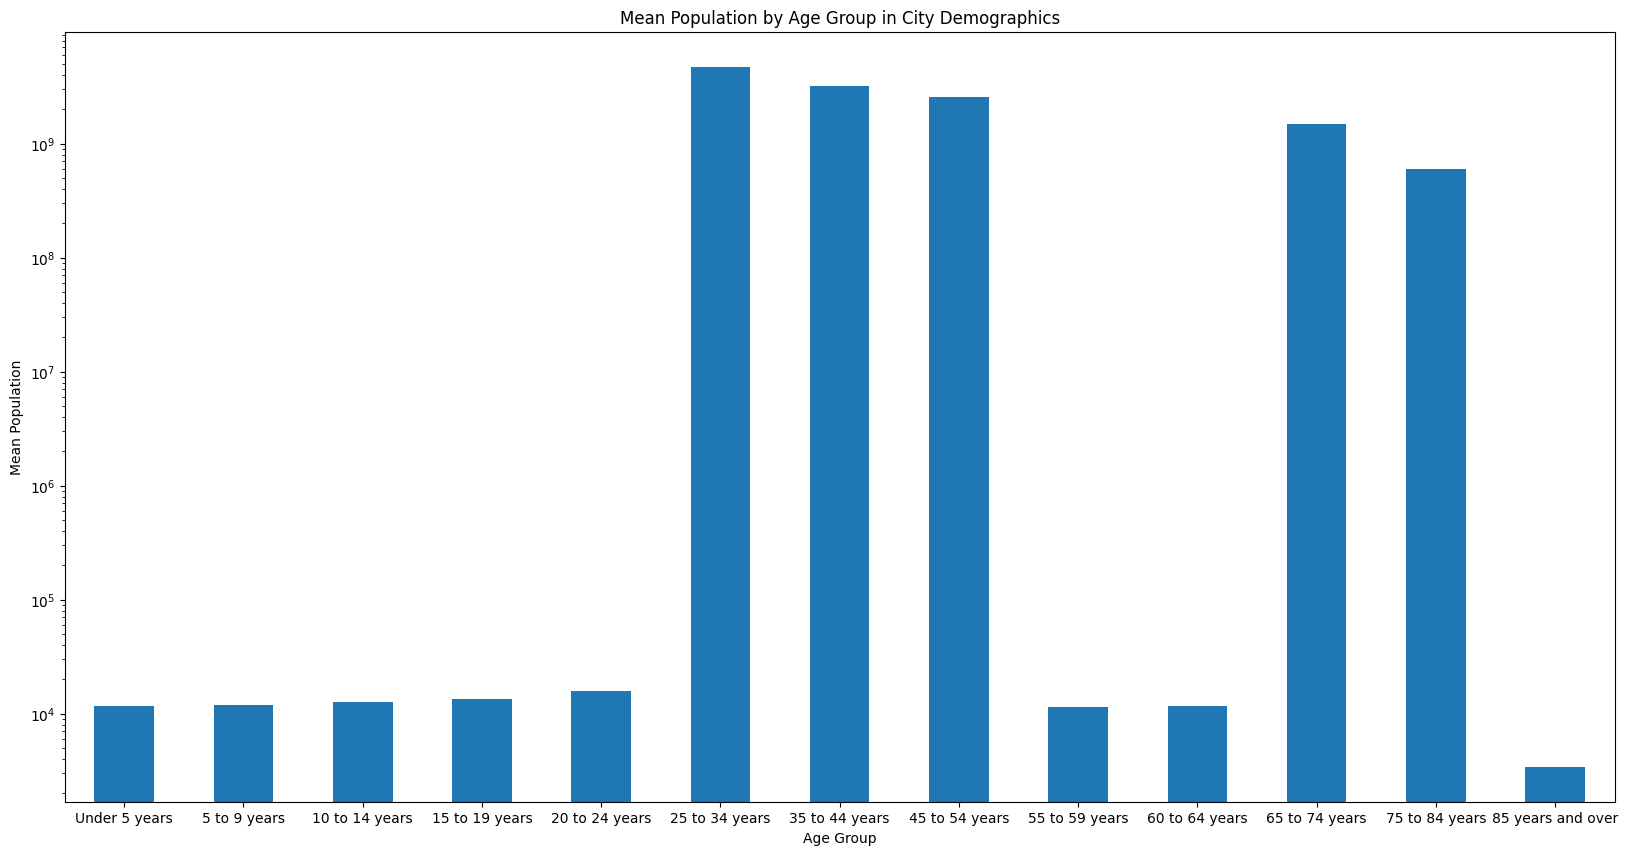

In [52]:
city_demo_df[age_groups].mean().plot.bar(logy=True, figsize=(20,10))
plt.xlabel('Age Group')
plt.ylabel('Mean Population')
plt.title('Mean Population by Age Group in City Demographics')
plt.xticks(rotation=0)
plt.show()

###County Demographics Dataset

In [54]:
county_demo_df.head()

,Geography,Geographic Area Name,Total population,Male,Female,Sex ratio (males per 100 females),Under 5 years,5 to 9 years,10 to 14 years,15 to 19 years,20 to 24 years,25 to 34 years,35 to 44 years,45 to 54 years,55 to 59 years,60 to 64 years,65 to 74 years,75 to 84 years,85 years and over,Median age (years),Under 18 years,16 years and over,18 years and over,21 years and over,62 years and over,65 years and over,18 years and over,18 years and over!!Male,18 years and over!!Female,18 years and over!!Sex ratio (males per 100 females),65 years and over,65 years and over!!Male,65 years and over!!Female,65 years and over!!Sex ratio (males per 100 females),RACE!!Total population,RACE!!One race,RACE!!Two or More Races,RACE!!One race,RACE!!One race!!White,RACE!!One race!!Black or African American,RACE!!One race!!American Indian and Alaska Native,RACE!!One race!!American Indian and Alaska Native!!Cherokee tribal grouping,RACE!!One race!!American Indian and Alaska Native!!Chippewa tribal grouping,RACE!!One race!!American Indian and Alaska Native!!Navajo tribal grouping,RACE!!One race!!American Indian and Alaska Native!!Sioux tribal grouping,RACE!!One race!!Asian,RACE!!One race!!Asian!!Asian Indian,RACE!!One race!!Asian!!Chinese,RACE!!One race!!Asian!!Filipino,RACE!!One race!!Asian!!Japanese,RACE!!One race!!Asian!!Korean,RACE!!One race!!Asian!!Vietnamese,RACE!!One race!!Asian!!Other Asian,RACE!!One race!!Native Hawaiian and Other Pacific Islander,RACE!!One race!!Native Hawaiian and Other Pacific Islander!!Chamorro,RACE!!One race!!Native Hawaiian and Other Pacific Islander!!Native Hawaiian,RACE!!One race!!Native Hawaiian and Other Pacific Islander!!Samoan,RACE!!One race!!Native Hawaiian and Other Pacific Islander!!Other Native Hawaiian and Other Pacific Islander,RACE!!One race!!Some Other Race,RACE!!Two or More Races,RACE!!Two or More Races!!White and Black or African American,RACE!!Two or More Races!!White and American Indian and Alaska Native,RACE!!Two or More Races!!White and Asian,RACE!!Two or More Races!!White and Some Other Race,RACE!!Two or More Races!!Black or African American and American Indian and Alaska Native,RACE!!Two or More Races!!Black or African American and Some Other Race,Race alone or in combination with one or more other races!!Total population,Race alone or in combination with one or more other races!!White,Race alone or in combination with one or more other races!!Black or African American,Race alone or in combination with one or more other races!!American Indian and Alaska Native,Race alone or in combination with one or more other races!!Asian,Race alone or in combination with one or more other races!!Native Hawaiian and Other Pacific Islander,Race alone or in combination with one or more other races!!Some Other Race,HISPANIC OR LATINO AND RACE!!Total population,HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race),HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Mexican,HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Puerto Rican,HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Cuban,HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race)!!Other Hispanic or Latino,HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino,HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!White alone,HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Black or African American alone,HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!American Indian and Alaska Native alone,HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Asian alone,HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Native Hawaiian and Other Pacific Islander alone,HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Some Other Race alone,HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Two or More Races,HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Two or More Races!!Two races including Some Other Race,"HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Two or More Races!!Two races excluding So

##Merged Dataset

In [55]:
merged_df.head()

,incident_id,data_year,ori,pug_agency_name,pub_agency_unit,agency_type_name,state_abbr,state_name,division_name,region_name,population_group_code,population_group_description,incident_date,adult_victim_count,juvenile_victim_count,total_offender_count,adult_offender_count,juvenile_offender_count,offender_race,offender_ethnicity,victim_count,offense_name,total_individual_victims,location_name,bias_desc,victim_types,multiple_offense,multiple_bias,incident_month,incident_day,bias0,bias1,bias2,bias3,bias4,Anti-American Indian or Alaska Native,Anti-Arab,Anti-Asian,Anti-Atheism/Agnosticism,Anti-Bisexual,Anti-Black or African American,Anti-Buddhist,Anti-Catholic,Anti-Church of Jesus Christ,"Anti-Eastern Orthodox (Russian, Greek, Other)",Anti-Female,Anti-Gay,Anti-Gender Non-Conforming,Anti-Heterosexual,Anti-Hindu,Anti-Hispanic or Latino,Anti-Islamic (Muslim),Anti-Jehovah's Witness,Anti-Jewish,Anti-LGBTQ,Anti-Lesbian,Anti-Male,Anti-Mental Disability,"Anti-Multiple Races, Group","Anti-Multiple Religions, Group",Anti-Native Hawaiian or Other Pacific Islander,Anti-Other Christian,Anti-Other Race/Ethnicity/Ancestry,Anti-Other Religion,Anti-Physical Disability,Anti-Protestant,Anti-Sikh,Anti-Transgender,Anti-White,victim_type_0,victim_type_1,victim_type_2,victim_type_3,victim_type_4,Business,Financial Institution,Government,Individual,Law Enforcement Officer,Other,Religious Organization,Society/Public,Unknown,nan_x,agency_type_name_City,agency_type_name_County,division_name_East North Central,division_name_East South Central,division_name_Middle Atlantic,division_name_Mountain,division_name_New England,division_name_Pacific,division_name_South Atlantic,division_name_West North Central,division_name_West South Central,offender_race_American Indian or Alaska Native,offender_race_Asian,offender_race_Black or African American,offender_race_Multiple,offender_race_Native Hawaiian or Other Pacific Islander,offender_race_Not Specified,offender_race_Unknown,offender_race_White,offender_ethnicity_Hispanic or Latino,offender_ethnicity_Multiple,offender_ethnicity_Not Hispanic or Latino,offender_ethnicity_Not Specified,offender_ethnicity_Unknown,offense_name_Aggravated Assault,offense_name_Aggravated Assault;All Other Larceny,offense_name_Aggravated Assault;Arson,offense_name_Aggravated Assault;Arson;Burglary/Breaking & Entering;Destruction/Damage/Vandalism of Property,offense_name_Aggravated Assault;Arson;Destruction/Damage/Vandalism of Property;Motor Vehicle Theft,offense_name_Aggravated Assault;Burglary/Breaking & Entering;Destruction/Damage/Vandalism of Property,offense_name_Aggravated Assault;Burglary/Breaking & Entering;Destruction/Damage/Vandalism of Property;Robbery;Weapon Law Violations,offense_name_Aggravated Assault;Burglary/Breaking & Entering;Kidnapping/Abduction;Simple Assault,offense_name_Aggravated Assault;Burglary/Breaking & Entering;Weapon Law Violations,offense_name_Aggravated Assault;Destruction/Damage/Vandalism of Property,offense_name_Aggravated Assault;Destruction/Damage/Vandalism of Property;Intimidation,offense_name_Aggravated Assault;Destruction/Damage/Vandalism of Property;Simple Assault,offense_name_Aggravated Assault;Destruction/Damage/Vandalism of Property;Weapon Law Violations,offense_name_Aggravated Assault;Intimidation,offense_name_Aggravated Assault;Kidnapping/Abduction,offense_name_Aggravated Assault;Murder and Nonnegligent Manslaughter,offense_name_Aggravated Assault;Robbery,offense_name_Aggravated Assault;Simple Assault,offense_name_Aggravated Assault;Weapon Law Violations,offense_name_All Other Larceny,offense_name_All Other Larceny;Animal Cruelty;Destruction/Damage/Vandalism of Property,offense_name_All Other Larceny;Destruction/Damage/Vandalism of Property,offense_name_All Other Larceny;Destruction/Damage/Vandalism of Property;Simple Assault,offense_name_All Other Larceny;Destruction/Damage/Vandalism of Property;Theft of Motor Vehicle Parts or Accessories,offense_name_All Other Larceny;Identity Theft,offense_name_Al

In [56]:
#convert the categorical columns to numerical ones and store the modified df as a new df for correlation analysis
categorical_to_int_df = merged_df
# Select only the numerical columns
numerical_cols = categorical_to_int_df.select_dtypes(include=['int64', 'float64', np.number]).drop(labels=["incident_id"], axis=1)
# numerical_cols

In [ ]:
# Create a correlation matrix
merged_corr = merged_df[int_columns].dropna().corr()

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7b1eaef1d000> (for post_execute):


KeyboardInterrupt: 

In [ ]:
# Create a heatmap of the correlation matrix
fig, ax = plt.subplots(figsize=(600,400))
sns.heatmap(corr, annot=True, ax=ax)

In [58]:
# merged_df["color"] = merged_df["region_name"].map({
#     "Midwest": "red",
#     "West": "yellow",
#     "Northeast": "green",
#     "South": "blue"
# })
# merged_df["size"] = merged_df.groupby(["incident_month", "region_name"]).count().reset_index()["incident_id"]

# #remove the max row limit for altair
# alt.data_transformers.disable_max_rows()

# alt.Chart(merged_df.dropna()).mark_circle().encode(
#     x="total_offender_count",
#     y="total_individual_victims",
#     color=alt.Color("color", scale=None),
#     size="size"
# )